In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
from qiskit import *
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 128    # Size of the train dataset
n_test = 32     # Size of the test dataset

SAVE_PATH = "quanvolution_pqc/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
BATCH_SIZE = 16

In [4]:

from torch.utils.data import SubsetRandomSampler
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.transforms.Compose([
                                 transforms.Resize(size=14),
                                 transforms.ToTensor() 
                             ]))
                            

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              download = False,
                              transform = transforms.transforms.Compose([
                                 transforms.Resize(size=14),
                                 transforms.ToTensor() 
                             ]))

train_sampler = SubsetRandomSampler(range(n_train))
test_sampler = SubsetRandomSampler(range(n_test))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          sampler = test_sampler)

In [5]:
for (x,y) in train_loader:
    print(torch.max(x[0],dim=2))
    break

torch.return_types.max(
values=tensor([[0.0000, 0.0000, 0.3882, 0.7647, 0.6471, 0.7294, 0.6706, 0.5608, 0.6000,
         0.6157, 0.6353, 0.7373, 0.3647, 0.0000]]),
indices=tensor([[0, 0, 6, 5, 5, 7, 7, 8, 8, 8, 8, 8, 7, 0]]))


In [6]:
token1 = '2b740fada862fb6d9683487f84455ff8fccb2caaa3988e4f406d321ef67ce0644eb679211a1b6a377ec5ee9b3839d34434255304ab535a9ed11ce60703f07446'
token2 = '08952555d263c29c9b015855d49bcbf0e7a3cb1354b5520743285bb48d19f0db420522be05c80dd1fb19179c42d798b238ae7b944568bb6e7e7284d9bfeb0209'

# from qiskit import IBMQ
# IBMQ.save_account(token2)
# provider = IBMQ.enable_account(token1)
dev = qml.device("default.qubit", wires=9)
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',provider=provider)
# IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',
                #  ibmqx_token=token1, hub='ibm-q', group='open', project='main')
# print(dev.capabilities()['backend'])
# import pennylane as qml
# from pennylane_ionq import ops

# dev = qml.device("ionq.qpu", wires=9)

# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params,circno=9):
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
    
    if circno == 2:     # len(params) == 18
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CNOT(wires=[i,i-1])    
    elif circno == 3:   # len(params) == 26
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for k,i in enumerate(range(n_qubits-1,0,-1)):
            qml.CRZ(params[k+2*n_qubits], wires=[i,i-1])
    elif circno == 9:   # len(params) == 9
        # PQC
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
        for i in range(n_qubits):
            qml.RX(params[i],wires=i)
    elif circno == 10:  # len(params) == 18
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
        qml.CZ(wires=[0,n_qubits-1])
        for i in range(n_qubits):
            qml.RY(params[i+n_qubits],wires=i)
    else:
        pass
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

In [7]:
print(pqc([1,0,2,1,2,3,1,2,0],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],circno=10))

tensor(-0.0852, dtype=torch.float64)


In [15]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True,opt=True):
        super().__init__()
        self.qc = qc
        self.opt = opt
        self.n_qubits = 9
        self.filters = 1
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(12,12,self.filters,2*self.n_qubits))
        self.q_params.requires_grad = True

    def forward(self, inputs):
        if self.qc == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12))
          for bat, image in enumerate(inputs):
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      for i in range(self.filters):
                          q_results = pqc(
                          [
                              image[0, j - 1, k - 1].item(),
                              image[0, j - 1, k].item(),
                              image[0, j - 1, k + 1].item(),
                              image[0, j, k - 1].item(),
                              image[0, j, k].item(),
                              image[0, j, k + 1].item(),
                              image[0, j + 1, k - 1].item(),
                              image[0, j + 1, k].item(),
                              image[0, j + 1, k + 1].item()
                          ],
                              self.q_params[j-1,k-1,i]
                          )
                          out[bat,i,j - 1, k - 1] = q_results
        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if self.opt==True:
          out = self.conv_opt(inputs)
        x = self.pool(F.relu(self.conv1(out)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x



In [16]:
# !pip3 install --upgrade torch

In [19]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=True,opt=False)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=0.01)
summary(model,(1,14,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         MaxPool2d-2              [-1, 8, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             584
         MaxPool2d-4              [-1, 8, 2, 2]               0
            Linear-5                   [-1, 16]             528
           Dropout-6                   [-1, 16]               0
            Linear-7                   [-1, 10]             170
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


<ipython-input-15-ca832c0ec1c3>:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


In [20]:
for p in model.parameters():
    print(p.shape)

torch.Size([12, 12, 1, 18])
torch.Size([1, 1, 3, 3])
torch.Size([1])
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [21]:
losses = []
val_accs = []
test_accs = []
for epoch in range(10000):
  train_loss = 0
  val_acc = 0
  for (x_train, y_train) in train_loader:
    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    val_acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  val_acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  if epoch%10 == 9:
    val_accs.append(val_acc)
    if epoch%100 == 99:
      print(epoch+1,train_loss,val_acc)
    losses.append(train_loss.item())
  if epoch%100 == 99:
    test_acc = 0
    for (x_test, y_test) in test_loader:
      outputs = model(x_test.cuda() if use_cuda else x_test)
      _, preds = torch.max(outputs,1)
      test_acc += (preds==(y_test.cuda() if use_cuda else y_test)).sum().item()
    test_acc /= n_test
    print("test_acc: ", test_acc)
    test_accs.append(test_acc)

  del test_acc 
  del val_acc

<ipython-input-15-ca832c0ec1c3>:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (40,)

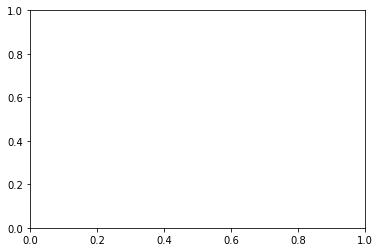

In [11]:
from matplotlib.pyplot import plot
x = np.arange(0,10000,10)
plot(x,losses)

In [ ]:
x = np.arange(0,10000,10)
plot(x,accs)